Loaded 722 patient records
Simulated dropout rate: 44.88% (324 patients)
Training set: 505 samples
Testing set: 217 samples

Model Performance:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       108
           1       0.72      0.55      0.62       109

    accuracy                           0.67       217
   macro avg       0.68      0.67      0.66       217
weighted avg       0.68      0.67      0.66       217

ROC AUC Score: 0.7204

Top 10 Important Features:
                   Feature  Importance
4         Disease_Severity    0.202535
0                      Age    0.195888
3                  N_Score    0.134236
2                  T_Score    0.118823
1            Tumor_Size_cm    0.107229
9       Age_Group_65_to_75    0.045517
5             Genetic_Risk    0.031268
11      Age_Group_Under_55    0.029865
8       Age_Group_55_to_65    0.026740
12  Tumor_Size_Group_Large    0.022236

Confusion Matrix:
[[85 23]
 [49 60]]
Feature impo

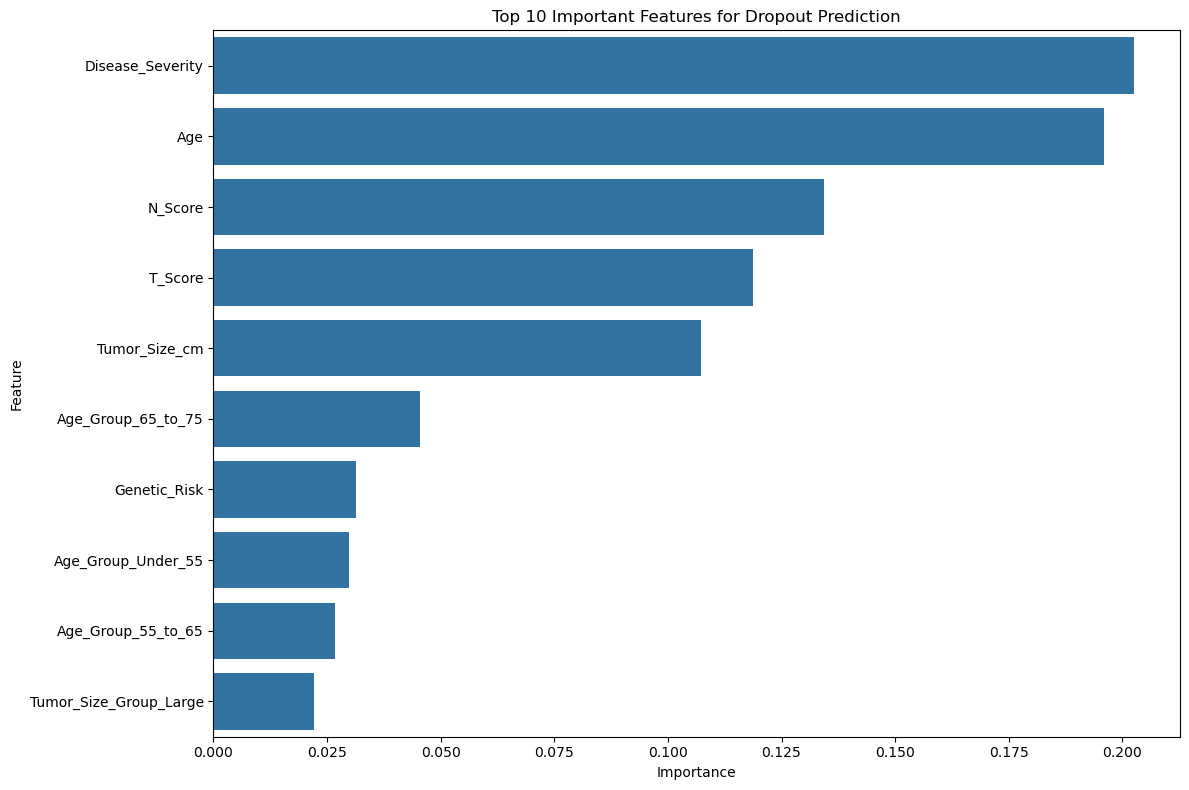

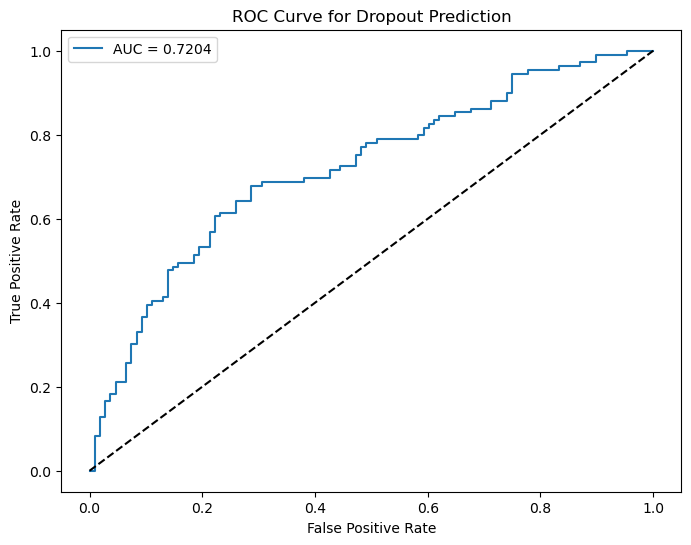

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Load the data
def load_data(file_path='core_clinical_data.csv'):
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} patient records")
    return df

# Simulate dropout events (since we don't have real dropout data)
def simulate_dropout(df):
    """
    Simulate trial dropout events based on clinical variables
    Returns a copy of the dataframe with dropout variables added
    """
    # Create a copy to avoid modifying the original
    df_with_dropout = df.copy()
    
    # Initialize dropout risk score for each patient
    dropout_risk = np.zeros(len(df))
    
    # Age factor (higher age = higher risk)
    dropout_risk += np.where(df['Age'] > 75, 3, 
                    np.where(df['Age'] > 65, 2,
                    np.where(df['Age'] > 55, 1, 0)))
    
    # Disease severity factor
    tumor_stage_risk = np.zeros(len(df))
    tumor_stage_risk = np.where(df['Path_Stage_pT'] == 'pT4', 3, tumor_stage_risk)
    tumor_stage_risk = np.where(df['Path_Stage_pT'] == 'pT3', 2, tumor_stage_risk)
    tumor_stage_risk = np.where(df['Path_Stage_pT'] == 'pT2', 1, tumor_stage_risk)
    dropout_risk += tumor_stage_risk
    
    node_stage_risk = np.zeros(len(df))
    node_stage_risk = np.where(df['Path_Stage_pN'] == 'pN3', 3, node_stage_risk)
    node_stage_risk = np.where(df['Path_Stage_pN'] == 'pN2', 2, node_stage_risk)
    node_stage_risk = np.where(df['Path_Stage_pN'] == 'pN1', 1, node_stage_risk)
    dropout_risk += node_stage_risk
    
    # Grade factor
    grade_risk = np.zeros(len(df))
    grade_risk = np.where(df['Histologic_Grade'] == 'G4 Undifferentiated', 3, grade_risk)
    grade_risk = np.where(df['Histologic_Grade'] == 'G3 Poorly differentiated', 2, grade_risk)
    dropout_risk += grade_risk
    
    # Survival event is highly associated with dropout
    dropout_risk += np.where(df['OS_event'] == 1, 4, 0)
    
    # Tumor size factor
    dropout_risk += np.where(df['Tumor_Size_cm'] > 5, 1, 0)
    
    # Mutations factor
    dropout_risk += np.where(df['TP53_mutation'] == 1, 1, 0)
    
    # Convert risk score to probability using sigmoid function
    dropout_prob = 1 / (1 + np.exp(-(dropout_risk - 6) / 2))
    
    # Assign dropout status based on probability
    np.random.seed(42)  # For reproducibility
    random_values = np.random.random(len(df))
    dropout_status = np.where(random_values < dropout_prob, 1, 0)
    
    # Add dropout information to dataframe
    df_with_dropout['dropout'] = dropout_status
    
    # Add simulated dropout day for those who dropped out
    df_with_dropout['dropout_day'] = np.nan
    dropout_indices = df_with_dropout.index[df_with_dropout['dropout'] == 1]
    
    max_days = 365  # Maximum trial length (1 year)
    min_days = 30   # Minimum days before dropout
    day_range = max_days - min_days
    
    # Higher risk leads to earlier dropout
    for idx in dropout_indices:
        prob = dropout_prob[idx]
        dropout_day = round(min_days + day_range * (1 - prob))
        df_with_dropout.loc[idx, 'dropout_day'] = dropout_day
    
    # Print dropout statistics
    total_dropouts = df_with_dropout['dropout'].sum()
    dropout_rate = total_dropouts / len(df_with_dropout) * 100
    print(f"Simulated dropout rate: {dropout_rate:.2f}% ({total_dropouts} patients)")
    
    return df_with_dropout

# Feature engineering
def engineer_features(df):
    """
    Create additional features that may be predictive of dropout
    """
    df_featured = df.copy()
    
    # Age groups
    df_featured['Age_Group'] = pd.cut(
        df['Age'], 
        bins=[0, 55, 65, 75, 100],
        labels=['Under_55', '55_to_65', '65_to_75', 'Over_75']
    )
    
    # Tumor size groups
    df_featured['Tumor_Size_Group'] = pd.cut(
        df['Tumor_Size_cm'],
        bins=[0, 2, 5, float('inf')],
        labels=['Small', 'Medium', 'Large']
    )
    
    # Disease severity score (combination of T and N stage)
    df_featured['T_Score'] = df['Path_Stage_pT'].map({
        'pT1': 1, 'pT2': 2, 'pT3': 3, 'pT4': 4
    }).fillna(0)
    
    df_featured['N_Score'] = df['Path_Stage_pN'].map({
        'pN0': 0, 'pN1': 1, 'pN2': 2, 'pN3': 3
    }).fillna(0)
    
    df_featured['Disease_Severity'] = df_featured['T_Score'] + df_featured['N_Score']
    
    # Genetic risk score
    df_featured['Genetic_Risk'] = (
        df_featured['PIK3CA_mutation'].fillna(0) + 
        df_featured['TP53_mutation'].fillna(0)
    )
    
    return df_featured

# Preprocessing for model training
def preprocess_data(df):
    """
    Handle missing values and prepare data for modeling
    """
    # Fill missing values
    impute_numeric = SimpleImputer(strategy='median')
    impute_categorical = SimpleImputer(strategy='most_frequent')
    
    # Select only relevant columns for the model
    numeric_features = ['Age', 'Tumor_Size_cm', 'T_Score', 'N_Score', 
                       'Disease_Severity', 'Genetic_Risk']
    categorical_features = ['Sex', 'Age_Group', 'Tumor_Size_Group']
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', impute_numeric),
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', impute_categorical),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ])
    
    return preprocessor

# Train the model
def train_model(df, target='dropout'):
    """
    Train a machine learning model to predict dropout
    """
    # Prepare features and target
    X = df.drop(['dropout', 'dropout_day', 'OS_days', 'OS_event', 'idx'], axis=1, errors='ignore')
    y = df[target]
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Testing set: {len(X_test)} samples")
    
    # Create preprocessing pipeline
    preprocessor = preprocess_data(X)
    
    # Create and train the model
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=100, 
            max_depth=5,
            min_samples_split=10,
            random_state=42
        ))
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluate the model
    print("\nModel Performance:")
    print(classification_report(y_test, y_pred))
    
    # ROC AUC score
    auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC Score: {auc:.4f}")
    
    # Feature importance
    feature_names = []
    for name, transformer, features in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(features)
        elif name == 'cat':
            for feature in features:
                # Get one-hot encoded feature names
                categories = transformer.named_steps['onehot'].categories_[features.index(feature)]
                feature_names.extend([f"{feature}_{cat}" for cat in categories])
    
    # Get feature importances from the Random Forest
    importances = model.named_steps['classifier'].feature_importances_
    
    # Only keep the number of importances that match our feature names
    importances = importances[:len(feature_names)]
    
    # Create a DataFrame with feature importances
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    print("\nTop 10 Important Features:")
    print(feature_importance.head(10))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    return model, feature_importance, (X_test, y_test, y_prob)

# Visualize feature importances
def plot_feature_importance(feature_importance):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    plt.title('Top 10 Important Features for Dropout Prediction')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("Feature importance plot saved as 'feature_importance.png'")

# Visualize ROC curve
def plot_roc_curve(test_data):
    X_test, y_test, y_prob = test_data
    from sklearn.metrics import roc_curve
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Dropout Prediction')
    plt.legend()
    plt.savefig('roc_curve.png')
    print("ROC curve plot saved as 'roc_curve.png'")

# Main function to run the entire pipeline
def main():
    # Load data
    data = load_data()
    
    # Add simulated dropout information
    data_with_dropout = simulate_dropout(data)
    
    # Engineer features
    featured_data = engineer_features(data_with_dropout)
    
    # Train and evaluate model
    model, feature_importance, test_data = train_model(featured_data)
    
    # Visualizations
    plot_feature_importance(feature_importance)
    plot_roc_curve(test_data)
    
    # Save processed data for dashboard integration
    featured_data.to_csv('processed_data_with_dropout.csv', index=False)
    print("Processed data saved to 'processed_data_with_dropout.csv'")
    
    # Example prediction for a new patient
    print("\nExample prediction for a new patient:")
    example_patient = featured_data.iloc[0:1].copy()
    example_patient.drop(['dropout', 'dropout_day'], axis=1, inplace=True, errors='ignore')
    
    dropout_prob = model.predict_proba(example_patient)[0, 1]
    print(f"Patient ID: {example_patient['idx'].values[0]}")
    print(f"Age: {example_patient['Age'].values[0]}")
    print(f"Sex: {example_patient['Sex'].values[0]}")
    print(f"Disease Severity: {example_patient['Disease_Severity'].values[0]}")
    print(f"Dropout Probability: {dropout_prob:.2%}")
    
    # Return everything for further usage
    return {
        'data': featured_data,
        'model': model,
        'feature_importance': feature_importance
    }

if __name__ == "__main__":
    main()

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, StackingClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# Load the data
def load_data(file_path='core_clinical_data.csv'):
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} patient records")
    return df

# Simulate dropout events (since we don't have real dropout data)
def simulate_dropout(df):
    """
    Simulate trial dropout events based on clinical variables
    Returns a copy of the dataframe with dropout variables added
    """
    # Create a copy to avoid modifying the original
    df_with_dropout = df.copy()
    
    # Initialize dropout risk score for each patient
    dropout_risk = np.zeros(len(df))
    
    # Age factor (higher age = higher risk)
    dropout_risk += np.where(df['Age'] > 75, 3, 
                    np.where(df['Age'] > 65, 2,
                    np.where(df['Age'] > 55, 1, 0)))
    
    # Disease severity factor
    tumor_stage_risk = np.zeros(len(df))
    tumor_stage_risk = np.where(df['Path_Stage_pT'] == 'pT4', 3, tumor_stage_risk)
    tumor_stage_risk = np.where(df['Path_Stage_pT'] == 'pT3', 2, tumor_stage_risk)
    tumor_stage_risk = np.where(df['Path_Stage_pT'] == 'pT2', 1, tumor_stage_risk)
    dropout_risk += tumor_stage_risk
    
    node_stage_risk = np.zeros(len(df))
    node_stage_risk = np.where(df['Path_Stage_pN'] == 'pN3', 3, node_stage_risk)
    node_stage_risk = np.where(df['Path_Stage_pN'] == 'pN2', 2, node_stage_risk)
    node_stage_risk = np.where(df['Path_Stage_pN'] == 'pN1', 1, node_stage_risk)
    dropout_risk += node_stage_risk
    
    # Grade factor
    grade_risk = np.zeros(len(df))
    grade_risk = np.where(df['Histologic_Grade'] == 'G4 Undifferentiated', 3, grade_risk)
    grade_risk = np.where(df['Histologic_Grade'] == 'G3 Poorly differentiated', 2, grade_risk)
    dropout_risk += grade_risk
    
    # Survival event is highly associated with dropout
    dropout_risk += np.where(df['OS_event'] == 1, 4, 0)
    
    # Tumor size factor
    dropout_risk += np.where(df['Tumor_Size_cm'] > 5, 1, 0)
    
    # Mutations factor
    dropout_risk += np.where(df['TP53_mutation'] == 1, 1, 0)
    
    # Convert risk score to probability using sigmoid function
    dropout_prob = 1 / (1 + np.exp(-(dropout_risk - 6) / 2))
    
    # Assign dropout status based on probability
    np.random.seed(42)  # For reproducibility
    random_values = np.random.random(len(df))
    dropout_status = np.where(random_values < dropout_prob, 1, 0)
    
    # Add dropout information to dataframe
    df_with_dropout['dropout'] = dropout_status
    
    # Add simulated dropout day for those who dropped out
    df_with_dropout['dropout_day'] = np.nan
    dropout_indices = df_with_dropout.index[df_with_dropout['dropout'] == 1]
    
    max_days = 365  # Maximum trial length (1 year)
    min_days = 30   # Minimum days before dropout
    day_range = max_days - min_days
    
    # Higher risk leads to earlier dropout
    for idx in dropout_indices:
        prob = dropout_prob[idx]
        dropout_day = round(min_days + day_range * (1 - prob))
        df_with_dropout.loc[idx, 'dropout_day'] = dropout_day
    
    # Print dropout statistics
    total_dropouts = df_with_dropout['dropout'].sum()
    dropout_rate = total_dropouts / len(df_with_dropout) * 100
    print(f"Simulated dropout rate: {dropout_rate:.2f}% ({total_dropouts} patients)")
    
    return df_with_dropout

# Advanced feature engineering
def engineer_features(df):
    """
    Create additional features that may be predictive of dropout
    """
    df_featured = df.copy()
    
    # Basic features
    
    # Age groups
    df_featured['Age_Group'] = pd.cut(
        df['Age'], 
        bins=[0, 55, 65, 75, 100],
        labels=['Under_55', '55_to_65', '65_to_75', 'Over_75']
    )
    
    # Tumor size groups
    df_featured['Tumor_Size_Group'] = pd.cut(
        df['Tumor_Size_cm'],
        bins=[0, 2, 5, float('inf')],
        labels=['Small', 'Medium', 'Large']
    )
    
    # Disease severity score (combination of T and N stage)
    df_featured['T_Score'] = df['Path_Stage_pT'].map({
        'pT1': 1, 'pT2': 2, 'pT3': 3, 'pT4': 4
    }).fillna(0)
    
    df_featured['N_Score'] = df['Path_Stage_pN'].map({
        'pN0': 0, 'pN1': 1, 'pN2': 2, 'pN3': 3
    }).fillna(0)
    
    df_featured['Disease_Severity'] = df_featured['T_Score'] + df_featured['N_Score']
    
    # Genetic risk score
    df_featured['Genetic_Risk'] = (
        df_featured['PIK3CA_mutation'].fillna(0) + 
        df_featured['TP53_mutation'].fillna(0)
    )
    
    # Advanced features
    
    # Interaction terms
    df_featured['Age_X_Disease'] = df_featured['Age'] * df_featured['Disease_Severity']
    df_featured['Age_X_Tumor_Size'] = df_featured['Age'] * df_featured['Tumor_Size_cm']
    
    # Squared terms for nonlinear relationships
    df_featured['Age_Squared'] = df_featured['Age'] ** 2
    df_featured['Disease_Severity_Squared'] = df_featured['Disease_Severity'] ** 2
    
    # Composite risk scores
    df_featured['Combined_Risk_Score'] = (
        df_featured['Age'] / 90 +  # Normalize age
        df_featured['Disease_Severity'] / 7 +  # Normalize disease severity
        df_featured['Tumor_Size_cm'] / 16  # Normalize tumor size
    ) / 3  # Average the normalized scores
    
    # Risk categories
    df_featured['Age_Risk'] = np.where(df_featured['Age'] > 75, 'High',
                              np.where(df_featured['Age'] > 65, 'Medium',
                              np.where(df_featured['Age'] > 55, 'Low', 'Very Low')))
    
    df_featured['Disease_Risk'] = np.where(df_featured['Disease_Severity'] >= 5, 'Very High',
                                  np.where(df_featured['Disease_Severity'] >= 3, 'High',
                                  np.where(df_featured['Disease_Severity'] >= 2, 'Medium', 'Low')))
    
    # Create ordinal values for histologic grade
    df_featured['Grade_Score'] = df_featured['Histologic_Grade'].map({
        'G1 Well differentiated': 1,
        'G2 Moderately differentiated': 2,
        'G3 Poorly differentiated': 3,
        'G4 Undifferentiated': 4
    }).fillna(2)  # Default to moderate if missing
    
    # Handle missing values for key features
    for col in ['Age', 'Tumor_Size_cm', 'T_Score', 'N_Score', 'Disease_Severity']:
        df_featured[f'{col}_Missing'] = df_featured[col].isna().astype(int)
    
    return df_featured

# Advanced preprocessing and modeling
def build_improved_model(df, target='dropout'):
    """
    Build and evaluate an improved model for dropout prediction
    """
    print("Building improved dropout prediction model...")
    
    # Prepare features and target
    X = df.drop(['dropout', 'dropout_day', 'idx'], axis=1, errors='ignore')
    y = df[target]
    
    # Split the data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Testing set: {len(X_test)} samples")
    
    # Define feature groups
    numeric_features = [
        'Age', 'Tumor_Size_cm', 'T_Score', 'N_Score', 'Disease_Severity', 
        'Genetic_Risk', 'Age_X_Disease', 'Age_X_Tumor_Size', 'Age_Squared',
        'Disease_Severity_Squared', 'Combined_Risk_Score', 'Grade_Score'
    ]
    
    categorical_features = [
        'Sex', 'Age_Group', 'Tumor_Size_Group', 'Age_Risk', 'Disease_Risk'
    ]
    
    # Define preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    # Define models to try
    models = {
        'random_forest': RandomForestClassifier(random_state=42),
        'gradient_boosting': GradientBoostingClassifier(random_state=42),
        'xgboost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'logistic_regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    # Create pipelines with SMOTE for class imbalance
    pipelines = {}
    for name, model in models.items():
        pipelines[name] = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])
    
    # Define hyperparameter grids for optimization
    param_grids = {
        'random_forest': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__class_weight': [None, 'balanced']
        },
        'gradient_boosting': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [3, 5],
            'classifier__subsample': [0.8, 1.0]
        },
        'xgboost': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [3, 5],
            'classifier__subsample': [0.8, 1.0],
            'classifier__colsample_bytree': [0.8, 1.0]
        },
        'logistic_regression': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__penalty': ['l2'],
            'classifier__class_weight': [None, 'balanced']
        }
    }
    
    # Cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Find best model for each type
    best_models = {}
    best_scores = {}
    
    for name, pipeline in pipelines.items():
        print(f"\nTuning {name}...")
        grid_search = GridSearchCV(
            pipeline, 
            param_grids[name], 
            cv=cv, 
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        best_scores[name] = grid_search.best_score_
        
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        print(f"Best cross-validation ROC AUC for {name}: {grid_search.best_score_:.4f}")
    
    # Create an ensemble of the best models
    print("\nBuilding ensemble model...")
    
    # Voting classifier (combines predictions from multiple models)
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', best_models['random_forest']),
            ('gb', best_models['gradient_boosting']),
            ('xgb', best_models['xgboost'])
        ],
        voting='soft'  # Use probability estimates for voting
    )
    
    # Stacking classifier (uses predictions as features for a meta-model)
    stacking_clf = StackingClassifier(
        estimators=[
            ('rf', best_models['random_forest']),
            ('gb', best_models['gradient_boosting']),
            ('xgb', best_models['xgboost'])
        ],
        final_estimator=LogisticRegression(random_state=42),
        cv=5
    )
    
    # Train and evaluate all models on the test set
    models_to_evaluate = {
        **best_models,
        'voting_ensemble': voting_clf,
        'stacking_ensemble': stacking_clf
    }
    
    results = {}
    feature_importances = {}
    
    for name, model in models_to_evaluate.items():
        print(f"\nEvaluating {name}...")
        
        # Train if not already trained
        if name not in best_models:
            model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        # Calculate Precision-Recall AUC
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall, precision)
        
        # Store results
        results[name] = {
            'classification_report': classification_rep,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        # Print results
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"PR AUC: {pr_auc:.4f}")
        print(f"Accuracy: {classification_rep['accuracy']:.4f}")
        print(f"Dropout class precision: {classification_rep['1']['precision']:.4f}")
        print(f"Dropout class recall: {classification_rep['1']['recall']:.4f}")
        print(f"Dropout class F1: {classification_rep['1']['f1-score']:.4f}")
        
        # Extract feature importances if available
        if hasattr(model, 'feature_importances_'):
            feature_importances[name] = model.feature_importances_
        elif name in ['random_forest', 'gradient_boosting', 'xgboost']:
            # For pipeline models, get the classifier step
            if hasattr(model.named_steps['classifier'], 'feature_importances_'):
                feature_importances[name] = model.named_steps['classifier'].feature_importances_
    
    # Determine the best model based on ROC AUC
    best_model_name = max(results, key=lambda name: results[name]['roc_auc'])
    best_model = models_to_evaluate[best_model_name]
    
    print(f"\nBest model based on ROC AUC: {best_model_name}")
    print(f"ROC AUC: {results[best_model_name]['roc_auc']:.4f}")
    print(f"PR AUC: {results[best_model_name]['pr_auc']:.4f}")
    
    # Feature importance for the best model (if available)
    if best_model_name in feature_importances:
        print("\nFeature Importances for the best model:")
        
        # Get feature names after preprocessing
        feature_names = []
        
        if best_model_name in ['random_forest', 'gradient_boosting', 'xgboost']:
            # Get transformed feature names
            preprocessor = best_model.named_steps['preprocessor']
            
            for name, transformer, features in preprocessor.transformers_:
                if name == 'num':
                    feature_names.extend(features)
                elif name == 'cat':
                    for feature in features:
                        categories = transformer.named_steps['onehot'].categories_[features.index(feature)]
                        feature_names.extend([f"{feature}_{cat}" for cat in categories])
                        
            # Limit to actual number of features used
            feature_names = feature_names[:len(feature_importances[best_model_name])]
            
            # Create and print importance table
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': feature_importances[best_model_name]
            }).sort_values('Importance', ascending=False)
            
            print(importance_df.head(15))
    
    # Save the best model
    joblib.dump(best_model, 'best_dropout_prediction_model.pkl')
    print("\nBest model saved as 'best_dropout_prediction_model.pkl'")
    
    # Plot confusion matrix for the best model
    plot_confusion_matrix(results[best_model_name]['confusion_matrix'])
    
    # Plot ROC curves
    plot_roc_curves(X_test, y_test, models_to_evaluate)
    
    # Return best model and results
    return {
        'best_model': best_model,
        'best_model_name': best_model_name,
        'results': results
    }

# Utility functions for visualization
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.close()
    print("Confusion matrix saved as 'confusion_matrix.png'")

def plot_roc_curves(X_test, y_test, models):
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve
        from sklearn.metrics import roc_curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        
        # Plot
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.4f})')
    
    # Add diagonal line
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Dropout Prediction Models')
    plt.legend(loc="lower right")
    plt.savefig('roc_curves.png')
    plt.close()
    print("ROC curves saved as 'roc_curves.png'")

# Main execution function
def main():
    # Load data
    data = load_data()
    
    # Add simulated dropout information
    data_with_dropout = simulate_dropout(data)
    
    # Engineer enhanced features
    featured_data = engineer_features(data_with_dropout)
    
    # Remove rows with excessive missing values
    featured_data = featured_data.dropna(thresh=len(featured_data.columns) - 5)
    
    # Build improved model
    model_results = build_improved_model(featured_data)
    
    # Save processed data for future use
    featured_data.to_csv('enhanced_data_with_dropout.csv', index=False)
    print("\nEnhanced data saved to 'enhanced_data_with_dropout.csv'")
    
    return model_results

if __name__ == "__main__":
    main()

Loaded 722 patient records
Simulated dropout rate: 44.88% (324 patients)
Building improved dropout prediction model...
Training set: 499 samples
Testing set: 214 samples

Tuning random_forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for random_forest: {'classifier__class_weight': None, 'classifier__max_depth': None, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best cross-validation ROC AUC for random_forest: 0.7519

Tuning gradient_boosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for gradient_boosting: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best cross-validation ROC AUC for gradient_boosting: 0.7409

Tuning xgboost...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:53:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:53:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:53:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:53:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packa

Best parameters for xgboost: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best cross-validation ROC AUC for xgboost: 0.7510

Tuning logistic_regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters for logistic_regression: {'classifier__C': 1.0, 'classifier__class_weight': None, 'classifier__penalty': 'l2'}
Best cross-validation ROC AUC for logistic_regression: 0.7498

Building ensemble model...

Evaluating random_forest...
ROC AUC: 0.7541
PR AUC: 0.6900
Accuracy: 0.6869
Dropout class precision: 0.6495
Dropout class recall: 0.6562
Dropout class F1: 0.6528

Evaluating gradient_boosting...
ROC AUC: 0.7883
PR AUC: 0.7270
Accuracy: 0.7150
Dropout class precision: 0.6804
Dropout class recall: 0.6875
Dropout class F1: 0.6839

Evaluating xgboost...
ROC AUC: 0.7896
PR AUC: 0.7287
Accuracy: 0.7103
Dropout class precision: 0.6889
Dropout class re

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:53:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


ROC AUC: 0.7835
PR AUC: 0.7217
Accuracy: 0.7056
Dropout class precision: 0.6813
Dropout class recall: 0.6458
Dropout class F1: 0.6631

Evaluating stacking_ensemble...


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:53:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:53:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.11/site-packa

ROC AUC: 0.7796
PR AUC: 0.7177
Accuracy: 0.6916
Dropout class precision: 0.6786
Dropout class recall: 0.5938
Dropout class F1: 0.6333

Best model based on ROC AUC: logistic_regression
ROC AUC: 0.8129
PR AUC: 0.7019

Best model saved as 'best_dropout_prediction_model.pkl'
Confusion matrix saved as 'confusion_matrix.png'
ROC curves saved as 'roc_curves.png'

Enhanced data saved to 'enhanced_data_with_dropout.csv'
